In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [26]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Flatten, Dense, Activation, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

keras.backend.set_image_dim_ordering('th')

![yolo-arch](./tiny-yolo.png "YOLO Architecture")

In [27]:
def yolov1_model():

    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, (3, 3), input_shape=(3, 448, 448),  padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Layer 2
    model.add(Convolution2D(32, (3, 3),  padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Layer 3
    model.add(Convolution2D(64, (3, 3), padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Layer 4
    model.add(Convolution2D(128, (3, 3),  padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Layer 5
    model.add(Convolution2D(256, (3, 3),  padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Layer 6
    model.add(Convolution2D(512, (3, 3), padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Layer 7
    model.add(Convolution2D(1024, (3, 3), padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))

    # Layer 8
    model.add(Convolution2D(1024, (3, 3), padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024, (3, 3), padding="same", strides=(1, 1)))
    model.add(LeakyReLU(alpha=0.1))
    
    # FC Layer 1
    model.add(Flatten())
    model.add(Dense(256))
    
    # FC Layer 2
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))

    # FC Layer 3
    model.add(Dense(1470))
    
    return model

In [28]:
tiny_modelv1 = yolov1_model()

In [29]:
tiny_modelv1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 16, 448, 448)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 224, 224)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 32, 224, 224)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 112, 112)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 112, 112)      18496     
__________

In [30]:
load_weights(tiny_modelv1, './yolo-tiny.weights')

In [31]:
from keras.utils import plot_model
plot_model(tiny_modelv1, to_file='model.png')

## Apply model to a test image 

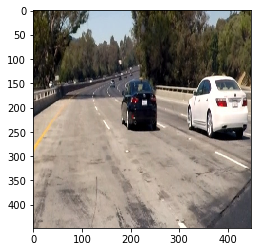

In [32]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))
plt.imshow(resized)

In [33]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = tiny_modelv1.predict(batch)

In [34]:
out

array([[0.07306323, 0.022391  , 0.04073805, ..., 0.55529416, 0.29223415,
        0.44075096]], dtype=float32)

In [35]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
print(boxes)

[]


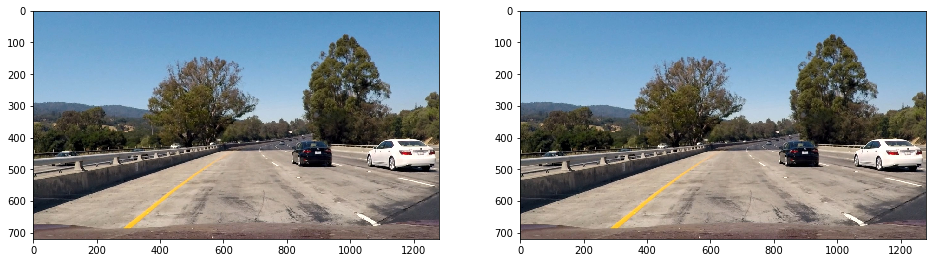

In [36]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

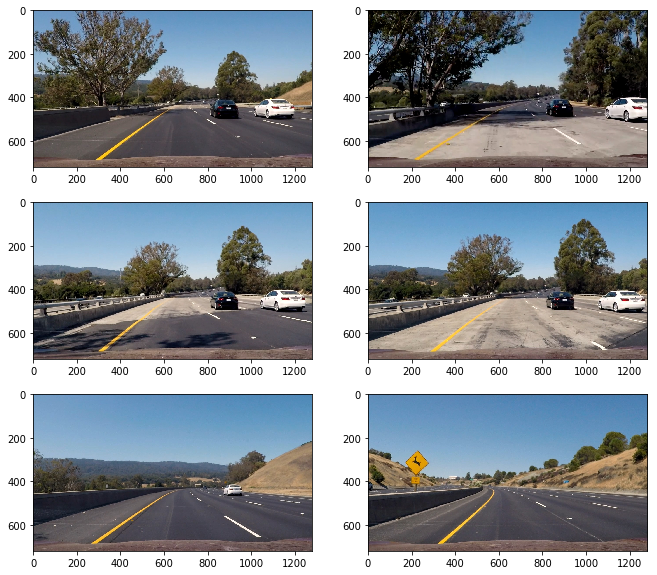

In [37]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = tiny_modelv1.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))